In [2]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

# import sys 
# sys.path.append('../')
#import feature_cleaning as feature_cleaning

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#sklearn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#sklearn other
#import graphviz 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score, roc_auc_score, auc, roc_curve
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
edu_df = pd.read_csv('edu_df_15.csv')

# split the data, choosing only edu cols
X = edu_df.drop(columns=[ 'Unnamed: 0', 'SERIALNO', 'FOD1P', 'FOD2P','SOCP','MAJ_SOCP','MAJ_SOCP_labels', 
                'MAJ_SOCP_15','FOD1P_labels','FOD2P_labels','SCHL',
                'SCHL_labels','FOD1P_MAJ_labels', 'FOD1P_MAJ'])
y = edu_df.loc[:,'MAJ_SOCP_15']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: MAJ_SOCP_15, dtype: int64

In [6]:


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42)


# model pipelines
#-----------------------------------
#-------------linear
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_l2 = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_sgd = Pipeline([('scl', StandardScaler()),
            ('clf', SGDClassifier(random_state=42))])


#-------------trees
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_rf_scl = Pipeline([('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_gb = Pipeline([('clf', GradientBoostingClassifier(random_state=42))])


#-------------SVM
pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=42))])


#-------------KNN
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

pipe_knn_scl = Pipeline([('scl', StandardScaler()),
            ('clf', KNeighborsClassifier())])

#-----------------------------------

#-------------XGB
pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])
#-----------------------------------


# grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
max_depth = [10,100,1000,10000]
max_depth2 = [10,100,1000]
alpha_range = [.1, .001, .00001, .000001]
gamma_range = [.1, 1, 10]

#-------------linear
grid_params_lr = [{'clf__penalty': ['l1'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear', ],  #,'saga'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}] 

grid_params_lr_l2 = [{'clf__penalty': ['l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],  #, 'sag'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}]

grid_params_sgd = [{'clf__loss': ['hinge', 'log', 'perceptron'],
        'clf__alpha': alpha_range,
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__class_weight': [None, 'balanced']}] 

#-------------trees
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': max_depth,
        'clf__min_samples_split': param_range[1:],
        'clf__class_weight': [None, 'balanced']}]

grid_params_rf = [{'clf__criterion': ['entropy'],
        'clf__min_samples_leaf': [1],
        'clf__max_depth': [1000],
        'clf__min_samples_split': [10],
        'clf__class_weight': [None],
        'clf__n_estimators':[10]}]

#<3
grid_params_gb = [{'clf__loss': ['deviance', 'exponential'],
        'clf__learning_rate': alpha_range,
        'clf__n_estimators': max_depth2,
        'clf__subsample': param_range_fl}]

#-------------SVM
grid_params_svm = [{'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__degree': param_range[1:],
        'clf__gamma': gamma_range,
        'clf__C': gamma_range,
        'clf__class_weight': [None, 'balanced']}]

#-------------KNN
grid_params_knn = [{'clf__n_neighbors': param_range}]

#-------------XGB

grid_params_xgb = [{}]

# #'clf__n_estimators': max_depth2,
#                    'clf__max_depth': max_depth,
#                    'clf__learning_rate':gamma_range

#--------------------------------------------------------------

# Construct grid searches
jobs = -1
verbose = 2

#-------------linear
gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose) 

gs_lr_l2 = GridSearchCV(estimator=pipe_lr_l2,
            param_grid=grid_params_lr_l2,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_sgd = GridSearchCV(estimator=pipe_sgd,
            param_grid=grid_params_sgd,
            scoring='f1_micro',
            cv=10,
            verbose=verbose)


#-------------trees    
gs_dt = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_dt,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf_scl = GridSearchCV(estimator=pipe_rf_scl,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#-------------SVM

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------KNN
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_knn_scl = GridSearchCV(estimator=pipe_knn_scl,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------XGB
gs_xgb = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#---------------------------------------------------------------------

# List of pipelines for ease of iteration
grids = [ gs_rf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'rf'}

# Fit the grid search objects
print('Performing model optimizations...')
best_f1_micro = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs = gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)

    # Best training data f1
    print('Best training f1: %.3f' % gs.best_score_)

    # Predict on test data with best params
    y_pred = gs.predict(X_test)

    #accuracy
    print('test accuracy {}:'.format( accuracy_score(y_test, y_pred)))
    
    #auc
    print('test auc {}:'.format( roc_auc_score(y_test, y_pred)))

    # Test data accuracy of model with best params
    print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))

    # Track best (highest test f1) model
    if f1_score(y_test, y_pred) > best_f1_micro:
        best_f1_micro = f1_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'rf_occ_15.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: rf
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[CV] clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10 
[C

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.8s remaining:    4.8s


[CV]  clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10, total=   2.6s
[CV]  clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10, total=   2.6s
[CV]  clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10, total=   2.4s
[CV]  clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10, total=   2.3s
[CV]  clf__class_weight=None, clf__criterion=entropy, clf__max_depth=1000, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=10, total=   2.2s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished


Best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 1000, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 10}
Best training f1: 0.968
test accuracy 0.9666264748944966:
test auc 0.6591084376962484:
Test set f1 score for best params: 0.417 

Classifier with best test set f1: rf

Saved rf grid search pipeline to file: rf_occ_15.pkl


In [7]:
gs.best_estimator_.named_steps["clf"].feature_importances_  
#trying to get feature importance out of the grid search. got it so much work...

array([1.31710326e-01, 3.39540628e-04, 1.98392933e-04, 3.26246914e-04,
       2.02800513e-03, 4.21297230e-03, 2.05032303e-03, 9.80716332e-04,
       1.89607245e-01, 2.37286211e-05, 2.01437586e-03, 6.50798462e-02,
       1.07564359e-02, 1.01272847e-03, 6.04989049e-04, 5.34271110e-04,
       5.03011949e-03, 9.63976174e-04, 4.05305042e-03, 1.81729450e-04,
       1.03148128e-03, 9.80532219e-06, 6.68847722e-03, 3.15313980e-05,
       6.78602772e-06, 6.76394107e-04, 5.61350138e-04, 7.61501194e-02,
       1.65085626e-03, 1.82978996e-04, 6.48399241e-04, 8.14964168e-04,
       4.03990662e-03, 5.46417550e-04, 9.20940699e-06, 1.82345914e-03,
       5.22029335e-04, 1.25212913e-03, 5.14648058e-03, 2.52973093e-03,
       9.59619898e-04, 5.27316622e-04, 1.23707128e-03, 2.55724985e-06,
       7.06569094e-04, 1.16521425e-04, 1.04807354e-03, 2.93674174e-03,
       6.72134933e-04, 3.39347550e-04, 7.22979362e-05, 4.26904849e-04,
       6.11793359e-04, 3.21462752e-04, 2.93607608e-05, 1.19249878e-03,
      

In [10]:
started around 3pm

1-0.9640853388454156


0.035914661154584415

In [11]:
0.9666264748944966-0.9640853388454156

0.0025411360490810164

In [12]:
0.0025411360490810164/0.035914661154584415

0.07075483848068122

In [8]:
y_pred_proba = gs.predict_proba(X_test)

In [10]:
print('test auc {}:'.format( roc_auc_score(y_test, y_pred_proba[:,1], average='micro')))

test auc 0.815653444124108:


In [11]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)


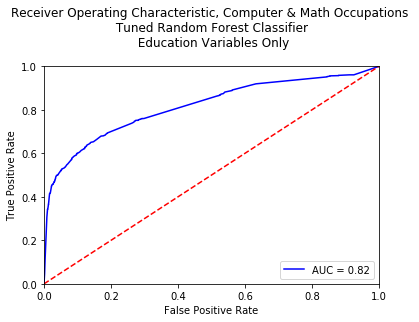

In [18]:
plt.title('Receiver Operating Characteristic, Computer & Math Occupations \n Tuned Random Forest Classifier \n Education Variables Only', pad=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
model = GradientBoostingClassifier(max_depth=2)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9682747674590285

In [79]:
model.score(X_test, y_test)

0.966798725346654

In [ ]:
#default train and test xgboost
0.9684039568876421
0.9669709757988115

#default train and test gradientboost
0.9690868152960284
0.9666264748944966

In [80]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.3962411902897416

In [119]:
X.columns

Index(['SCHL_ord', 'FOD1P_MAJ__Agriculture, agriculture operations, and related sciences', 'FOD1P_MAJ__Architecture and related services', 'FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies', 'FOD1P_MAJ__Biological and biomedical sciences', 'FOD1P_MAJ__Business, management, marketing, and related support services', 'FOD1P_MAJ__Communication, journalism, and related programs', 'FOD1P_MAJ__Communications technologies/technicians and support services', 'FOD1P_MAJ__Computer and information sciences and support services', 'FOD1P_MAJ__Construction trades',
       ...
       'SCHL__Grade 7', 'SCHL__Grade 8', 'SCHL__Grade 9', 'SCHL__Kindergarten', 'SCHL__Master's degree', 'SCHL__No schooling completed', 'SCHL__Nursery school, preschool', 'SCHL__Professional degree beyond a bachelor's degree', 'SCHL__Regular high school diploma', 'SCHL__Some college, but less than 1 year'], dtype='object', length=388)

In [214]:
featurelist = list(model.feature_importances_)
sortedfeaturelist = sorted(model.feature_importances_, reverse=True)
sortedfeaturelist

[0.11914826560306084,
 0.0931000712845908,
 0.0646061517266379,
 0.062247565571827305,
 0.05811885253063443,
 0.0577909405870056,
 0.0572214753082776,
 0.04791660273311943,
 0.03973253782385361,
 0.03693579312734581,
 0.029158499027566124,
 0.02494030490376411,
 0.02053489658594159,
 0.020438642867088155,
 0.01769890861114655,
 0.017116514228818217,
 0.016721452348570018,
 0.016691617948843256,
 0.013544545984845072,
 0.01348382109175228,
 0.011026801535859594,
 0.010232981947232838,
 0.009621947918080744,
 0.008557287611433205,
 0.00803711435368663,
 0.007932905205416335,
 0.007094660399397584,
 0.006462594317432097,
 0.005558504985954991,
 0.005437182878926741,
 0.00532422530166156,
 0.005313174551788871,
 0.0052773238470862115,
 0.004968879277116493,
 0.004849409425343478,
 0.00481927448692477,
 0.004150500937013183,
 0.004075732906665525,
 0.004060597990164573,
 0.003943053960733952,
 0.0038732095431333042,
 0.0038731335021193747,
 0.003810846753314416,
 0.003768658765656068,
 0.00

In [192]:
featurelist.index(0.03973253782385361)

187

Convenience plot with ``partial_dependence_plots``


AttributeError: 'Figure' object has no attribute 'title'

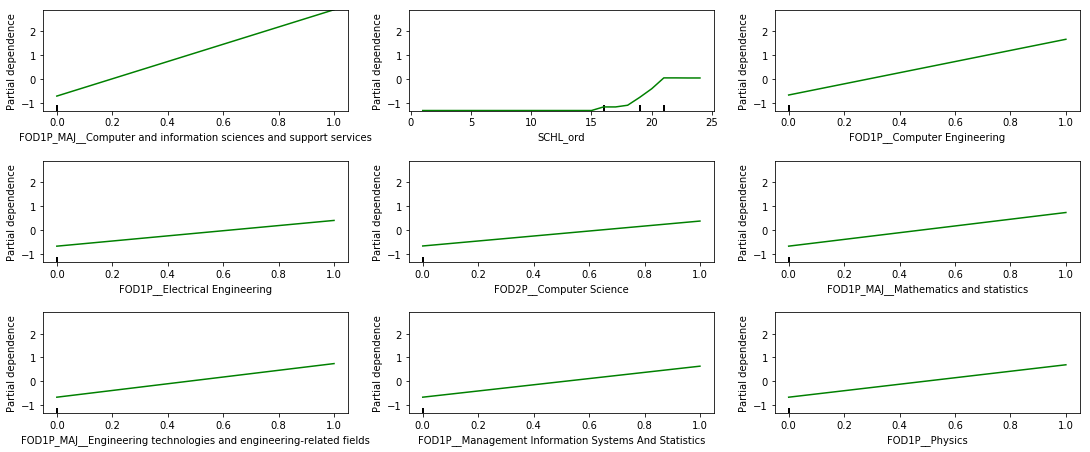

In [209]:

print('Convenience plot with ``partial_dependence_plots``')

features = [8, 0, 75, 91, 247, 22, 12, 139, 187]
fig, axs = plot_partial_dependence(model, 
                                   X_train, 
                                   features,
                                   feature_names=X.columns,
                                   n_jobs=-1, 
                                   grid_resolution=50)
#fig.suptitle('Partial dependence plots of pre diabetes on risk factors')
            
plt.subplots_adjust(bottom=.0001, right=2.5, top=1.4, wspace=.2, hspace=.5)  # tight_layout causes overlap with suptitle
fig.title('Partial Dependences: Most Important Features on CS Occupation')   


Convenience plot with ``partial_dependence_plots``


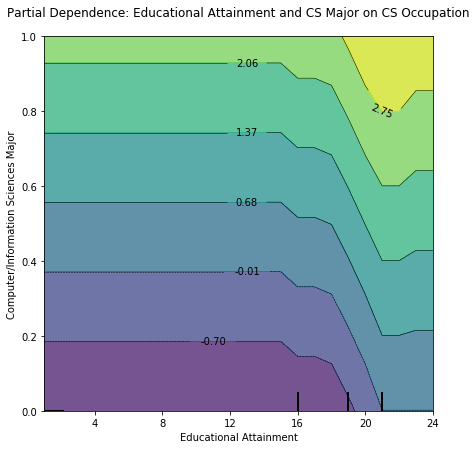

In [187]:
print('Convenience plot with ``partial_dependence_plots``')

features = [(0,8)]
fig, axs = plot_partial_dependence(model, 
                                   X_train, 
                                   features,
                                   feature_names=X.columns,
                                   n_jobs=-1, 
                                   grid_resolution=50)
#fig.suptitle('Partial dependence plots of pre diabetes on risk factors')
            
plt.subplots_adjust(bottom=.1, right=1, top=1.4, wspace=.2, hspace=.5)  # tight_layout causes overlap with suptitle
plt.xlabel('Educational Attainment')
plt.ylabel('Computer/Information Sciences Major')
plt.title('Partial Dependence: Educational Attainment and CS Major on CS Occupation', pad=20.0);

Custom 3d plot via ``partial_dependence``


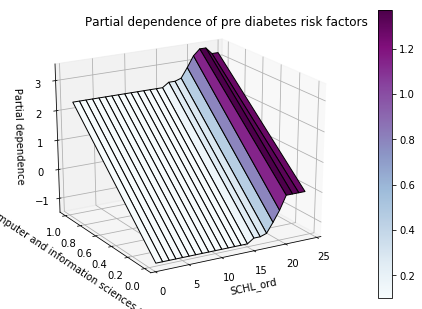

In [160]:
from mpl_toolkits.mplot3d import Axes3D
print('Custom 3d plot via ``partial_dependence``')
fig = plt.figure()

target_feature = (0, 8)
pdp, axes = partial_dependence(model, target_feature,X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(X.columns[target_feature[0]])
ax.set_ylabel(X.columns[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=240)
plt.colorbar(surf)
plt.suptitle('Partial dependence of pre diabetes risk factors')
                 
plt.subplots_adjust(right=1,top=.9)

''

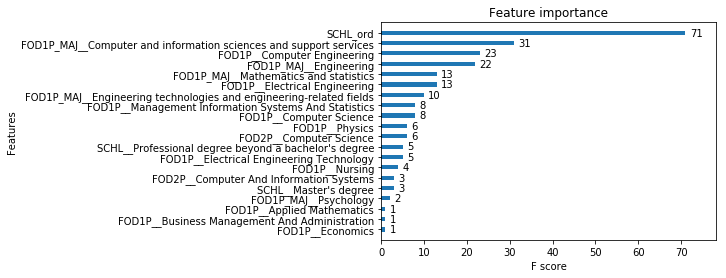

In [71]:
plt.Figure(figsize=(10,30))
xgb.plot_importance(model, grid=False, height=.4)
;

In [263]:
from sklearn.model_selection import cross_validate, cross_val_predict

rfmodel = RandomForestClassifier(criterion='entropy', class_weight=None, max_depth=1000, min_samples_leaf=1, min_samples_split=10)
gridsearchrf

rfscore = cross_validate(rfmodel, X_train, y_train, scoring=('accuracy','f1_micro'),cv=10, return_train_score=True)
print(rfscore.keys())

#print(rfmodel.score(X_test, y_test))
#b4 cv
# 0.9694559279492101
# 0.9664972870553785

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1_micro', 'train_f1_micro'])


In [264]:
for name, item in rfscore.items():
    print(name, item.mean())
    
#these are all still within training data - make no mistake

fit_time 1.1351121187210083
score_time 0.027295398712158202
test_accuracy 0.9675918354413187
train_accuracy 0.9695687107228848
test_f1_micro 0.9675918354413187
train_f1_micro 0.9695687107228848


In [270]:
rf_y_pred = rfscore.fit(X_test)
# f1_score(y_test, rf_y_pred)
# accuracy_score(y_test, rf_y_pred)

AttributeError: 'dict' object has no attribute 'fit'

Text(0.5,1,'Feature Importances on CS Occupation Using Random Forest')

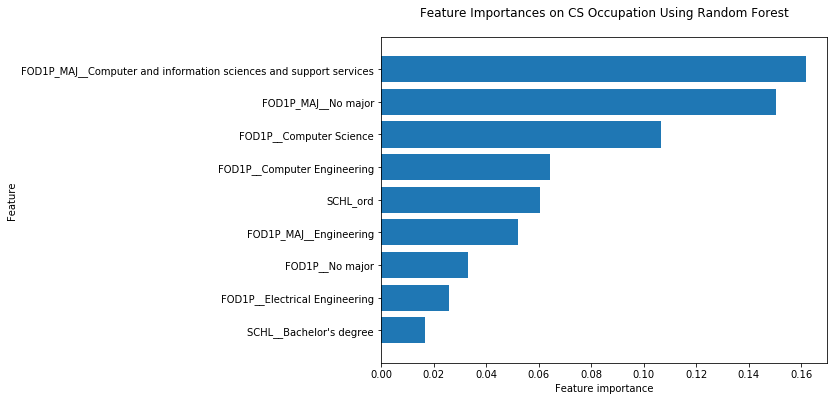

In [253]:
rfimportances = rfmodel.feature_importances_
indices = np.argsort(rfimportances)[::-1][0:9]

def plot_feature_importances(rfmodel):
    plt.figure(figsize=(8,6))
    n_features = 9
    plt.barh(range(n_features), rfimportances[indices], align='center')
    plt.yticks(np.arange(n_features), [X.columns[i] for i in indices])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(rfmodel)
plt.gca().invert_yaxis()
plt.title("Feature Importances on CS Occupation Using Random Forest", pad=20)

In [248]:
indices = np.argsort(rfimportances)[::-1][0:9]
indices

array([  8,  27,  78,  75,   0,  11, 172,  91, 367])

In [229]:
sortedrffeaturelist

[0.16188749901642574,
 0.1502256890550296,
 0.10653265783621184,
 0.06441619552956374,
 0.060639233921322436,
 0.05211174735663441,
 0.03299597211492971,
 0.025881461909581082,
 0.01665842538249896,
 0.01294013920953636,
 0.01264614695209495,
 0.010433377056329827,
 0.00935127493019455,
 0.008685369496779833,
 0.008303290601330221,
 0.0082259891914726,
 0.0070851358262239775,
 0.0066980853175161404,
 0.0064566654927826995,
 0.0058397722233275535,
 0.0051712341060120666,
 0.00511191430349737,
 0.004598438587982279,
 0.004507572857450728,
 0.0039302501210417475,
 0.003787345394508939,
 0.0036222568548128346,
 0.0035263013377825917,
 0.0034525226971271125,
 0.0034251708465393715,
 0.0028271035268454445,
 0.0026301931617243634,
 0.0023917914586823684,
 0.002334060761341836,
 0.0022968519209074804,
 0.0022804663333517187,
 0.0022663687726411684,
 0.0022342362015687145,
 0.002179977329852698,
 0.0021620727930164547,
 0.002040962329803912,
 0.0019484418793573508,
 0.0019103324180049452,
 0.00

In [19]:
X.head()

,SCHL_ord,"FOD1P_MAJ__Agriculture, agriculture operations, and related sciences",FOD1P_MAJ__Architecture and related services,"FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies",FOD1P_MAJ__Biological and biomedical sciences,"FOD1P_MAJ__Business, management, marketing, and related support services","FOD1P_MAJ__Communication, journalism, and related programs",FOD1P_MAJ__Communications technologies/technicians and support services,FOD1P_MAJ__Computer and information sciences and support services,FOD1P_MAJ__Construction trades,FOD1P_MAJ__Education,FOD1P_MAJ__Engineering,FOD1P_MAJ__Engineering technologies and engineering-related fields,FOD1P_MAJ__English language and literature/letters,FOD1P_MAJ__Family and consumer sciences/human sciences,"FOD1P_MAJ__Foreign languages, literatures, and linguistics",FOD1P_MAJ__Health professions and related programs,FOD1P_MAJ__History,"FOD1P_MAJ__Homeland security, law enforcement, firefighting and related protective services",FOD1P_MAJ__Legal professions and studies,"FOD1P_MAJ__Liberal arts and sciences, general studies and humanities",FOD1P_MAJ__Library science,FOD1P_MAJ__Mathematics and statistics,FOD1P_MAJ__Mechanic and repair technologies/technicians,"FOD1P_MAJ__Military science, leadership and operational art",FOD1P_MAJ__Multi/interdisciplinary studies,FOD1P_MAJ__Natural resources and conservation,FOD1P_MAJ__No major,"FOD1P_MAJ__Parks, recreation, leisure, and fitness studies",FOD1P_MAJ__Personal and culinary services,FOD1P_MAJ__Philosophy and religious studies,FOD1P_MAJ__Physical sciences,FOD1P_MAJ__Psychology,FOD1P_MAJ__Public administration and social service professions,FOD1P_MAJ__Science technologies/technicians,FOD1P_MAJ__Social sciences,FOD1P_MAJ__Theology and religious vocations,FOD1P_MAJ__Transportation and materials moving,FOD1P_MAJ__Visual and performing arts,FOD1P__Accounting,FOD1P__Actuarial Science,FOD1P__Advertising And Public Relations,FOD1P__Aerospace Engineering,FOD1P__Agricultural Economics,FOD1P__Agriculture Production And Management,FOD1P__Animal Sciences,FOD1P__Anthropology And Archeology,FOD1P__Applied Mathematics,FOD1P__Architectural Engineering,FOD1P__Architecture,FOD1P__Area Ethnic And Civilization Studies,FOD1P__Art And Music Education,FOD1P__Art History And Criticism,FOD1P__Astronomy And Astrophysics,FOD1P__Atmospheric Sciences And Meteorology,FOD1P__Biochemical Sciences,FOD1P__Biological Engineering,FOD1P__Biology,FOD1P__Biomedical Engineering,FOD1P__Botany,FOD1P__Business Economics,FOD1P__Business Management And Administration,FOD1P__Chemical Engineering,FOD1P__Chemistry,FOD1P__Civil Engineering,FOD1P__Clinical Psychology,FOD1P__Cognitive Science And Biopsychology,FOD1P__Commercial Art And Graphic Design,FOD1P__Communication Disorders Sciences And Services,FOD1P__Communication Technologies,FOD1P__Communications,FOD1P__Community And Public Health,FOD1P__Composition And Rhetoric,FOD1P__Computer Administration Management And Security,FOD1P__Computer And Information Systems,FOD1P__Computer Engineering,FOD1P__Computer Networking And Telecommunications,FOD1P__Computer Programming And Data Processing,FOD1P__Computer Science,FOD1P__Construction Services,FOD1P__Cosmetology Services And Culinary Arts,FOD1P__Counseling Psychology,FOD1P__Court Reporting,FOD1P__Criminal Justice And Fire Protection,FOD1P__Criminology,FOD1P__Drama And Theater Arts,FOD1P__Early Childhood Education,FOD1P__Ecology,FOD1P__Economics,FOD1P__Educational Administration And Supervision,FOD1P__Educational Psychology,FOD1P__Electrical Engineering,FOD1P__Electrical Engineering Technology,"FOD1P__Electrical, Mechanical, And Precision Technologies And Production",FOD1P__Elementary Education,FOD1P__Engineering And Industrial Management,FOD1P__Engineering Mechanics Physics And Science,FOD1P__Engineering Technologies,FOD1P__English Language And Literature,FOD1P__Environmental Engineering,FOD1P__Environmental Science,FOD1P__Family And Consumer Sciences,FOD1P__Film Video And Photographic Arts,FOD1P__F